In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score, recall_score

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import warnings
import pandas as pd
from early_stopping import EarlyStopping

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")


In [133]:
def get_lr_scheduler(scheduler_name, optimizer, **kwargs):
    """
    Function to get a specific learning rate scheduler instance.

    Args:
        scheduler_name (str): Name of the desired scheduler type.
        optimizer (torch.optim.Optimizer): Optimizer instance.
        **kwargs: Additional keyword arguments to be passed to the scheduler constructor.

    Returns:
        torch.optim.lr_scheduler._LRScheduler: Instance of the specified learning rate scheduler.
    """
    if scheduler_name == 'StepLR':
        return lr_scheduler.StepLR(optimizer, **kwargs)
    elif scheduler_name == 'MultiStepLR':
        return lr_scheduler.MultiStepLR(optimizer, **kwargs)
    elif scheduler_name == 'ExponentialLR':
        return lr_scheduler.ExponentialLR(optimizer, **kwargs)
    elif scheduler_name == 'CosineAnnealingLR':
        return lr_scheduler.CosineAnnealingLR(optimizer, **kwargs)
    elif scheduler_name == 'ReduceLROnPlateau':
        return lr_scheduler.ReduceLROnPlateau(optimizer, **kwargs)
    else:
        raise ValueError(f"Unsupported scheduler name: {scheduler_name}")

In [136]:
def calculate_metrics(epoch,metric_type, loss, labels, predictions):
    return {
        "epoch": [epoch],
        "metric_type": [metric_type],
        "accuracy": [accuracy_score(labels, predictions)],
        "precision": [precision_score(labels, predictions, average="weighted")],
        "recall": [recall_score(labels, predictions, average="weighted")],
        "f1": [f1_score(labels, predictions, average="weighted")],
        "loss" : [loss]
    }

def log_metrics(writer, metrics):
    # Log metrics to TensorBoard
    for key, value in metrics.items():
        if key != "epoch" and key != "metric_type":  # Exclude non-numeric values
            writer.add_scalar(f"{metrics['metric_type'][0]}/{key}", value[0], metrics['epoch'][0])

In [ ]:
args = {
    'epoch': 30,
    'train_batch_size' : 64,
    'val_batch_size' : 128,
    'num_workers': 2,
    'lr' : 0.001,
    'adam_eps' : 1e-8,
    'adam_beta1' : 0.9,
    'adam_beta2' : 0.999,
    'adam_weight_decay': 0.01,
    'lr_scheduler_type': 'CosineAnnealingLR',

    'es_patience': 3,
    'es_delta': 0,
}



In [111]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [112]:
#  Load datasets
train_dataset = datasets.ImageFolder('D:/Személyes/Tanulmányok/ELTE IK/Prog Inf MSc/4.félév/Diplomamunka/repo/mri_processing/data/kaggle_brain_tumor/Training', transform=train_transform)
test_dataset = datasets.ImageFolder('D:/Személyes/Tanulmányok/ELTE IK/Prog Inf MSc/4.félév/Diplomamunka/repo/mri_processing/data/kaggle_brain_tumor/Testing', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=args['train_batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=args['val_batch_size'], shuffle=False)

In [119]:


def train_model(model, criterion, optimizer, es_checker:EarlyStopping, num_epochs, device):
    # Tensorboard writer
    writer = SummaryWriter()    
    metrics_df = pd.DataFrame(columns=['epoch', 'metric_type', 'loss', "accuracy", "precision", "recall", "f1"])
     
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_predictions = []
        all_train_labels = []

        # Wrap train_loader with tqdm for progress visualization
        train_loader_with_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in train_loader_with_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_train_predictions.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_with_progress.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item() / labels.size(0)})

        train_loss = running_loss / len(train_loader)
        train_metrics = calculate_metrics(epoch, 'train', train_loss, all_train_labels, all_train_predictions)

        new_df = pd.DataFrame.from_dict(train_metrics)
        metrics_df = pd.concat([metrics_df, new_df], ignore_index=True)


        log_metrics(writer, train_metrics)

        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_predictions = []
        all_val_labels = []
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_predictions.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
            

            val_loss = val_loss / len(test_loader)
                

        val_metrics = calculate_metrics(epoch, 'val', val_loss, all_val_labels, all_val_predictions)

        new_df = pd.DataFrame.from_dict(val_metrics)
        metrics_df = pd.concat([metrics_df, new_df], ignore_index=True)

        log_metrics(writer, val_metrics)

        print(f"Epoch {epoch+1}/{num_epochs}")

        es_checker(val_loss, model)
        if es_checker.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    writer.close()
    return model, metrics_df


In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = get_lr_scheduler(args["scheduler_type"], optimizer)
es_checker = EarlyStopping(args["es_patience"], True, args["es_delta"], path="best_checkpoint.pt")

In [120]:
# Train the model
results = train_model(model, criterion, optimizer, es_checker, num_epochs=args['epoch'], device)

C:\Users\Csabi\AppData\Local\Temp\ipykernel_23544\3277487590.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_df], ignore_index=True)


Epoch 1/30


Epoch 2/30


Epoch 3/30


Epoch 4/30


Epoch 5/30


Epoch 6/30


Epoch 7/30


Epoch 8/30


Epoch 9/30


Epoch 10/30


Epoch 11/30


Epoch 12/30


Epoch 13/30


Epoch 14/30


Epoch 15/30


Epoch 16/30


Epoch 17/30


Epoch 18/30


Epoch 19/30


Epoch 20/30


Epoch 21/30


Epoch 22/30


Epoch 23/30


Epoch 24/30


Epoch 25/30


Epoch 26/30


Epoch 27/30


Epoch 28/30


Epoch 29/30


Epoch 30/30


In [122]:
results.head()

,epoch,metric_type,loss,accuracy,precision,recall,f1
0,0,train,0.689610,0.764006,0.762843,0.764006,0.761096
1,0,val,0.510760,0.803204,0.806403,0.803204,0.800557
2,1,train,0.432204,0.853992,0.854305,0.853992,0.853599
3,1,val,0.434886,0.835240,0.843481,0.835240,0.836624
4,2,train,0.367860,0.872549,0.873414,0.872549,0.872575


In [127]:
train_res = results[results.metric_type == 'train']
val_res = results[results.metric_type == 'val']

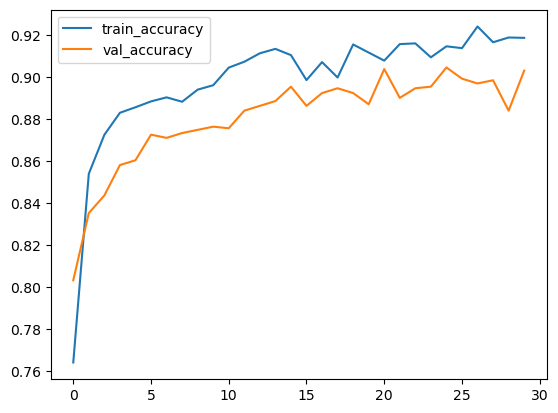

In [132]:
plt.plot(train_res['epoch'],train_res['accuracy'], label='train_accuracy')
plt.plot(val_res['epoch'],val_res['accuracy'], label='val_accuracy')
plt.legend()
plt.show()

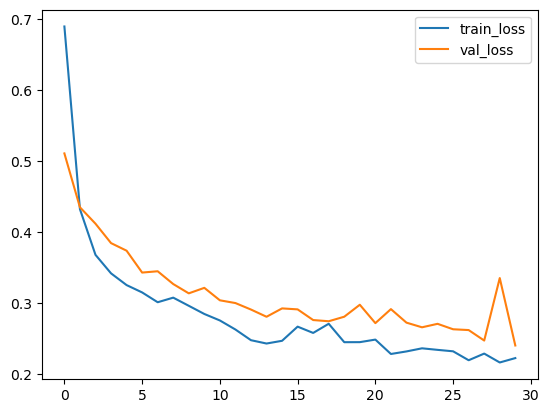

In [131]:
plt.plot(train_res['epoch'],train_res['loss'], label='train_loss')
plt.plot(val_res['epoch'],val_res['loss'], label='val_loss')
plt.legend()
plt.show()

In [36]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:


# Get predictions for test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_predictions, classes=test_dataset.classes)

# Show some results
# You can print some images with their predicted and true labels to visually inspect the performance of the model


Test Accuracy: 0.425629290617849


NameError: name 'plot_confusion_matrix' is not defined

Initial DataFrame:
   A  B  C
0  1  4  7
1  2  5  8
2  3  6  9

DataFrame after adding new elements:
    A   B   C
0   1   4   7
1   2   5   8
2   3   6   9
3  10  12  14
4  11  13  15


In [22]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have defined your model, criterion, and test_loader previously
writer = SummaryWriter('runs')
for i in range(5):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_predictions = []
        all_labels = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total

    writer.add_scalar('val_loss', val_loss, i)
    #writer.add_scalar('Train/Accuracy', train_accuracy, epoch)

# # Calculate metrics
# metrics = calculate_metrics(all_labels, all_predictions)
# metrics['loss'] = val_loss

# # Convert metrics to DataFrame
# metrics_df = pd.DataFrame(metrics, index=[0])

# print(metrics_df)


In [29]:
writer = SummaryWriter('runs')
for i in range(10):
    writer.add_scalar('alma', i, i)

writer.flush()
writer.close() 

In [26]:
%tensorboard 

^C


In [28]:
import os
os.listdir()

['dino.ipynb',
 'figure_creation.ipynb',
 'model_sandbox.ipynb',
 'output',
 'resnet.ipynb',
 'runs']

In [30]:
writer = SummaryWriter('asd')
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()